In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from itertools import combinations

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Matplotlib is building the font cache; this may take a moment.


In [2]:
# --- 1. Load and Prepare Data ---
print("--- 1. Loading and Preparing Data ---")

# Load the datasets
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    gender_submission_df = pd.read_csv('gender_submission.csv')
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please make sure 'train.csv', 'test.csv', and 'gender_submission.csv' are in the same directory.")
    exit()


# For this analysis, we will focus on the training data for model building and evaluation.
# The 'Survived' column is our target.
df = train_df.copy()

# Define features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Identify numeric and categorical features
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# Create preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data preparation complete.\n")



--- 1. Loading and Preparing Data ---
Data preparation complete.



In [3]:
# --- 2. Classification Models ---
print("--- 2. Building Classification Models ---")
print("Training Decision Tree Classifier...")
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])
dt_pipeline.fit(X_train, y_train)
print("Decision Tree training complete.")

print("Training k-NN Classifier...")
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier(n_neighbors=5))])
knn_pipeline.fit(X_train, y_train)
print("k-NN training complete.\n")

--- 2. Building Classification Models ---
Training Decision Tree Classifier...
Decision Tree training complete.
Training k-NN Classifier...
k-NN training complete.



In [4]:
# --- 3. Hyperparameter Tuning (for Decision Tree) ---
print("--- 3. Hyperparameter Tuning for Decision Tree ---")
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
print("Running GridSearchCV...")
grid_search.fit(X_train, y_train)
best_dt_pipeline = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}\n")


--- 3. Hyperparameter Tuning for Decision Tree ---
Running GridSearchCV...
Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best cross-validation accuracy: 0.8190



--- 4. Evaluating Tuned Decision Tree Model ---
Accuracy on Test Set: 0.8045
F1 Score on Test Set: 0.7328



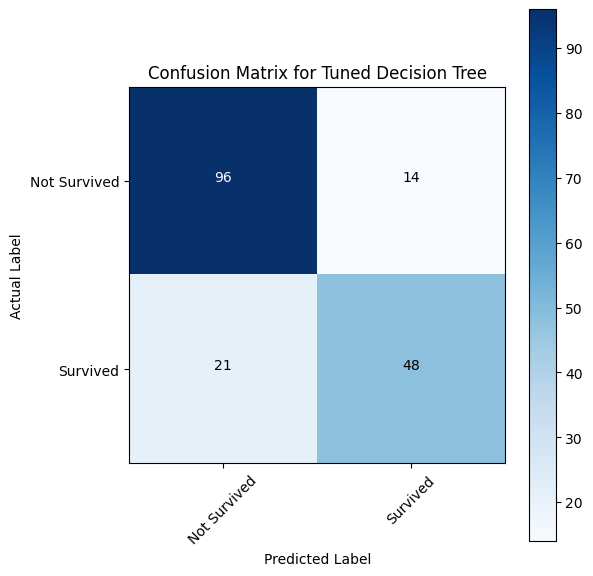

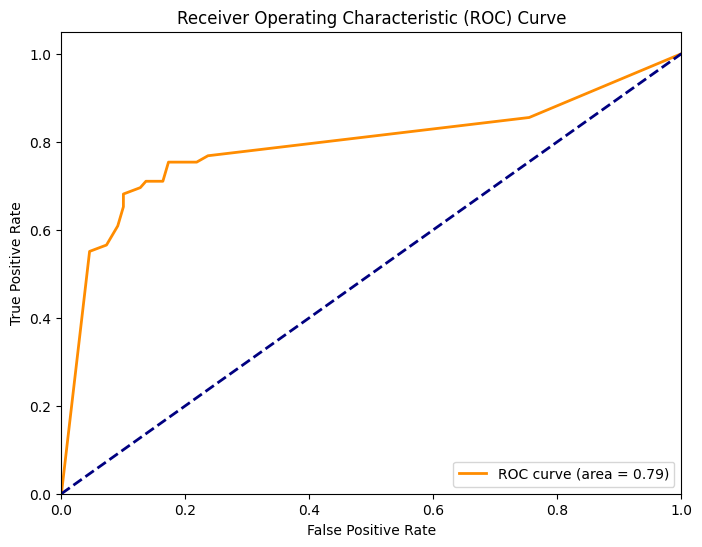

In [5]:

# --- 4. Evaluate Classification Model Performance (Tuned Decision Tree) ---
print("--- 4. Evaluating Tuned Decision Tree Model ---")
y_pred = best_dt_pipeline.predict(X_test)
y_pred_proba = best_dt_pipeline.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}\n")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
classes = ['Not Survived', 'Survived']
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Tuned Decision Tree')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


--- 5. Building and Visualizing K-Means Clustering Model ---


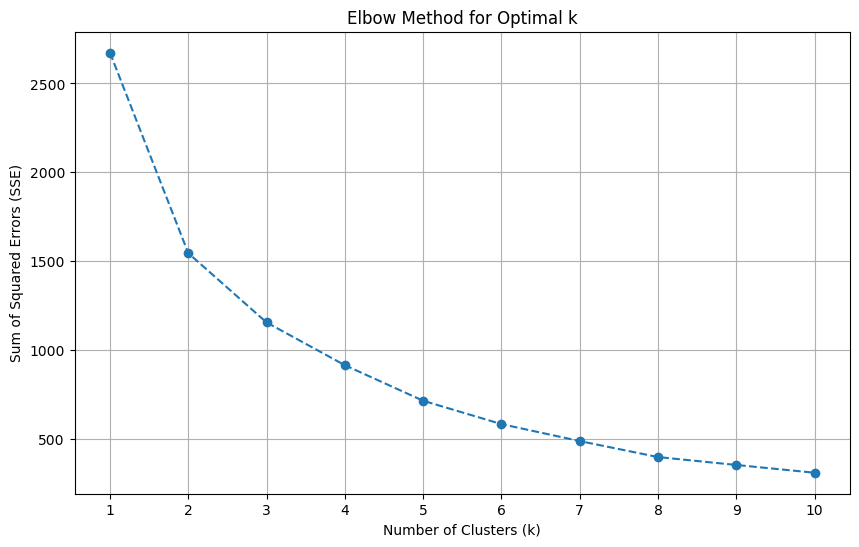

Based on the elbow plot, k=3 seems like a reasonable choice.


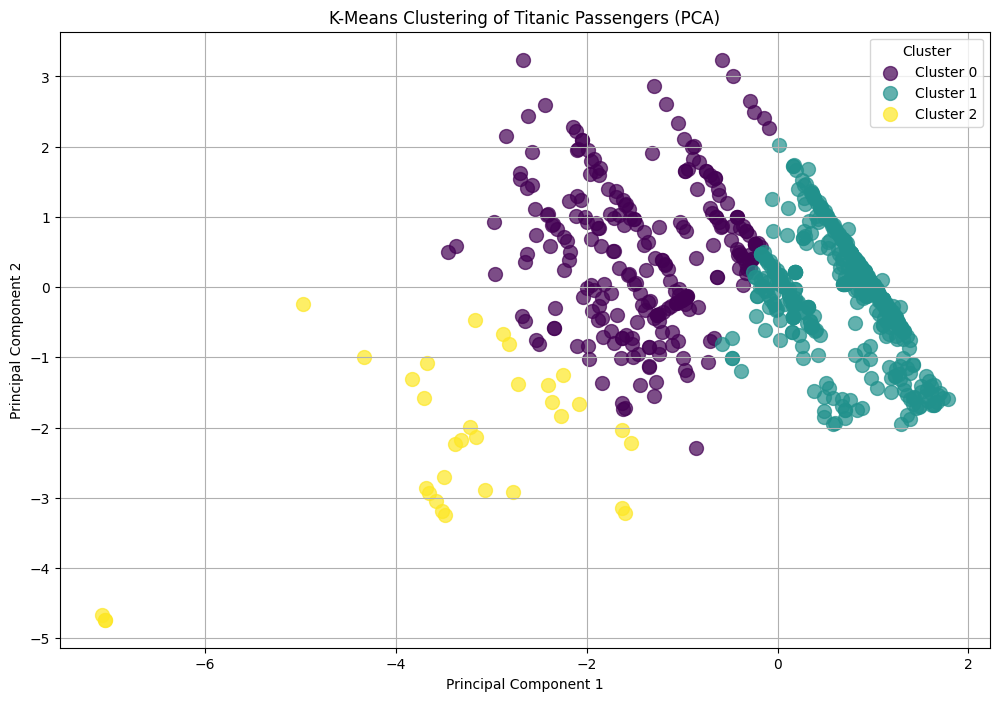


--- Cluster Analysis ---

Cluster 0 Characteristics:
              Age        Fare      Pclass    Survived
count  226.000000  252.000000  252.000000  252.000000
mean    41.800885   47.914699    1.297619    0.547619
std     13.490415   32.804198    0.507625    0.498718
min      4.000000    0.000000    1.000000    0.000000
25%     33.000000   26.000000    1.000000    0.000000
50%     40.000000   35.250000    1.000000    1.000000
75%     51.000000   75.510425    2.000000    1.000000
max     80.000000  153.462500    3.000000    1.000000
Survival Rate in Cluster 0: 0.55

Cluster 1 Characteristics:
              Age        Fare      Pclass    Survived
count  459.000000  606.000000  606.000000  606.000000
mean    23.848039   15.073617    2.800330    0.298680
std     10.965809   12.619563    0.400082    0.458057
min      0.420000    0.000000    2.000000    0.000000
25%     18.000000    7.796850    3.000000    0.000000
50%     24.000000    9.220850    3.000000    0.000000
75%     30.000000   1

In [6]:
# --- 5. Clustering Model (K-Means) ---
print("\n--- 5. Building and Visualizing K-Means Clustering Model ---")
cluster_features = ['Age', 'Fare', 'Pclass']
cluster_data = df[cluster_features].copy()
imputer = SimpleImputer(strategy='median')
cluster_data['Age'] = imputer.fit_transform(cluster_data[['Age']])
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Elbow Method
sse = []
for k_cluster in range(1, 11):
    kmeans = KMeans(n_clusters=k_cluster, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()
print("Based on the elbow plot, k=3 seems like a reasonable choice.")

# Apply K-Means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(cluster_data_scaled)
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_data_scaled)
df['PCA1'] = cluster_pca[:, 0]
df['PCA2'] = cluster_pca[:, 1]

# Visualize clusters
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, k))
for i in range(k):
    cluster_points = df[df['Cluster'] == i]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'],
                s=100, c=[colors[i]], label=f'Cluster {i}', alpha=0.7)
plt.title('K-Means Clustering of Titanic Passengers (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Explain clusters
print("\n--- Cluster Analysis ---")
for i in range(k):
    print(f"\nCluster {i} Characteristics:")
    print(df[df['Cluster'] == i][cluster_features + ['Survived']].describe())
    print(f"Survival Rate in Cluster {i}: {df[df['Cluster'] == i]['Survived'].mean():.2f}")

In [7]:
# --- 6. Association Rule Mining (Apriori from Scratch) ---
print("\n--- 6. Association Rule Mining (Apriori from Scratch) ---")

# --- Data Preparation for Association Rules ---
assoc_df = df[['Pclass', 'Sex', 'Age', 'Survived']].copy()
assoc_df['Age'].fillna(assoc_df['Age'].median(), inplace=True)
assoc_df['AgeBin'] = pd.cut(assoc_df['Age'], bins=[0, 12, 20, 40, 80], labels=['Child', 'Teen', 'Adult', 'Senior'])
assoc_df.drop('Age', axis=1, inplace=True)
assoc_df['Survived'] = assoc_df['Survived'].apply(lambda x: 'Survived_Yes' if x == 1 else 'Survived_No')
assoc_df['Pclass'] = 'Pclass_' + assoc_df['Pclass'].astype(str)
assoc_df_encoded = pd.get_dummies(assoc_df)

# --- Custom Apriori Implementation ---
def get_frequent_itemsets(df, min_support):
    """Generates frequent itemsets from a one-hot encoded DataFrame."""
    # Get support for 1-itemsets
    support = df.mean()
    frequent_items = support[support >= min_support]
    
    frequent_itemsets = {1: pd.DataFrame({'itemsets': [frozenset([col]) for col in frequent_items.index], 'support': frequent_items.values})}
    
    k = 1
    while True:
        k += 1
        # Generate candidate itemsets of size k
        prev_itemsets = frequent_itemsets[k-1]['itemsets'].tolist()
        candidates = set()
        for i in range(len(prev_itemsets)):
            for j in range(i + 1, len(prev_itemsets)):
                union_set = prev_itemsets[i].union(prev_itemsets[j])
                if len(union_set) == k:
                    candidates.add(union_set)
        
        if not candidates:
            break
            
        # Calculate support for candidates
        candidate_support = defaultdict(int)
        for _, row in df.iterrows():
            items_in_row = set(row[row].index)
            for candidate in candidates:
                if candidate.issubset(items_in_row):
                    candidate_support[candidate] += 1
        
        num_transactions = len(df)
        frequent_k_itemsets = []
        for itemset, count in candidate_support.items():
            support_val = count / num_transactions
            if support_val >= min_support:
                frequent_k_itemsets.append({'itemsets': itemset, 'support': support_val})
        
        if not frequent_k_itemsets:
            break
        
        frequent_itemsets[k] = pd.DataFrame(frequent_k_itemsets)

    # Combine all frequent itemsets into one DataFrame
    all_frequent = pd.concat(frequent_itemsets.values(), ignore_index=True)
    return all_frequent

def generate_association_rules(frequent_itemsets, metric="lift", min_threshold=1):
    """Generates association rules from frequent itemsets."""
    itemset_support_dict = {row['itemsets']: row['support'] for _, row in frequent_itemsets.iterrows()}
    rules = []

    for _, row in frequent_itemsets.iterrows():
        itemset = row['itemsets']
        support = row['support']
        
        if len(itemset) > 1:
            for i in range(1, len(itemset)):
                for antecedent in map(frozenset, combinations(itemset, i)):
                    consequent = itemset - antecedent
                    
                    if antecedent and consequent:
                        antecedent_support = itemset_support_dict.get(antecedent, 0)
                        consequent_support = itemset_support_dict.get(consequent, 0)
                        
                        if antecedent_support > 0:
                            confidence = support / antecedent_support
                            lift = confidence / consequent_support if consequent_support > 0 else 0
                            
                            if metric == "lift" and lift >= min_threshold:
                                rules.append((antecedent, consequent, support, confidence, lift))
                            elif metric == "confidence" and confidence >= min_threshold:
                                rules.append((antecedent, consequent, support, confidence, lift))
    
    rules_df = pd.DataFrame(rules, columns=['antecedents', 'consequents', 'support', 'confidence', 'lift'])
    return rules_df

# Run the custom Apriori and generate rules
min_support = 0.05
frequent_itemsets = get_frequent_itemsets(assoc_df_encoded, min_support)
rules = generate_association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort rules and display
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
print("\nTop 10 Association Rules:")
print(rules.head(10))

print("""
--- Insights from Association Rules ---
The rules reveal strong patterns. For example:
- The rule {Sex_female} -> {Survived_Yes} shows that female passengers had a high probability of survival. This is a well-known fact about the Titanic disaster.
- The rule {Pclass_3} -> {Survived_No} indicates that passengers in the third class had a high likelihood of not surviving.
- The combination of being female and in a higher class (e.g., Pclass_1 or Pclass_2) leads to an even stronger association with survival.

Real-world Application:
In a modern context, like managing a large-scale evacuation or emergency response, these types of rules can be invaluable. For instance, an emergency management system could use demographic and location data (analogous to 'Sex' and 'Pclass') to predict which groups of people are most at risk and prioritize resources accordingly. It highlights the importance of not treating a population as a monolith but rather as distinct groups with different needs and risk factors during a crisis.
""")



--- 6. Association Rule Mining (Apriori from Scratch) ---


<ipython-input-7-c5fb24c01850>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  assoc_df['Age'].fillna(assoc_df['Age'].median(), inplace=True)



Top 10 Association Rules:
                                           antecedents  \
163        (AgeBin_Adult, Pclass_Pclass_1, Sex_female)   
77                       (Pclass_Pclass_1, Sex_female)   
93             (Pclass_Pclass_1, Survived_Survived_No)   
201  (AgeBin_Adult, Survived_Survived_No, Pclass_Pc...   
133            (Survived_Survived_No, Pclass_Pclass_2)   
199          (AgeBin_Adult, Sex_male, Pclass_Pclass_2)   
105                      (Sex_female, Pclass_Pclass_2)   
123                 (Sex_female, Survived_Survived_No)   
89               (AgeBin_Senior, Survived_Survived_No)   
186           (AgeBin_Teen, Sex_male, Pclass_Pclass_3)   

                 consequents   support  confidence      lift  
163  (Survived_Survived_Yes)  0.059484    0.981481  2.557018  
77   (Survived_Survived_Yes)  0.102132    0.968085  2.522116  
93                (Sex_male)  0.086420    0.962500  1.486287  
201               (Sex_male)  0.070707    0.940299  1.452003  
133               (